## Финальный проект
# Прогнозирование временных рядов на примере датасета COVID 19 - ConfirmedCases/Fatalities
### Автор:
### Вера Лобанова lobanova_vs@mail.ru


# 1  Загрузка и визуализация данных

In [ ]:
# Импортируем необходимые библиотеки
# !pip install stldecompose
# !pip install ml_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import ml_metrics as metrics

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv(r"/content/train.csv", sep = ',') # загружаем данные в датафрейм
data['Date'] = pd.to_datetime(data['Date']) # изменяем формат столбца с датами
data.head(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
5,6,NaN,Afghanistan,2020-01-27,0.0,0.0
6,7,NaN,Afghanistan,2020-01-28,0.0,0.0
7,8,NaN,Afghanistan,2020-01-29,0.0,0.0
8,9,NaN,Afghanistan,2020-01-30,0.0,0.0
9,10,NaN,Afghanistan,2020-01-31,0.0,0.0


In [ ]:
rus = data[data['Country_Region']=='Russia'] # сохраняем данные по России в отдельный датафрейм
rus.describe()

,Id,ConfirmedCases,Fatalities
count,115.000000,115.000000,115.000000
mean,23518.000000,34485.121739,316.017391
std,33.341666,66301.390293,612.931624
min,23461.000000,0.000000,0.000000
25%,23489.500000,2.000000,0.000000
50%,23518.000000,199.000000,1.000000
75%,23546.500000,29973.000000,252.500000
max,23575.000000,262843.000000,2418.000000


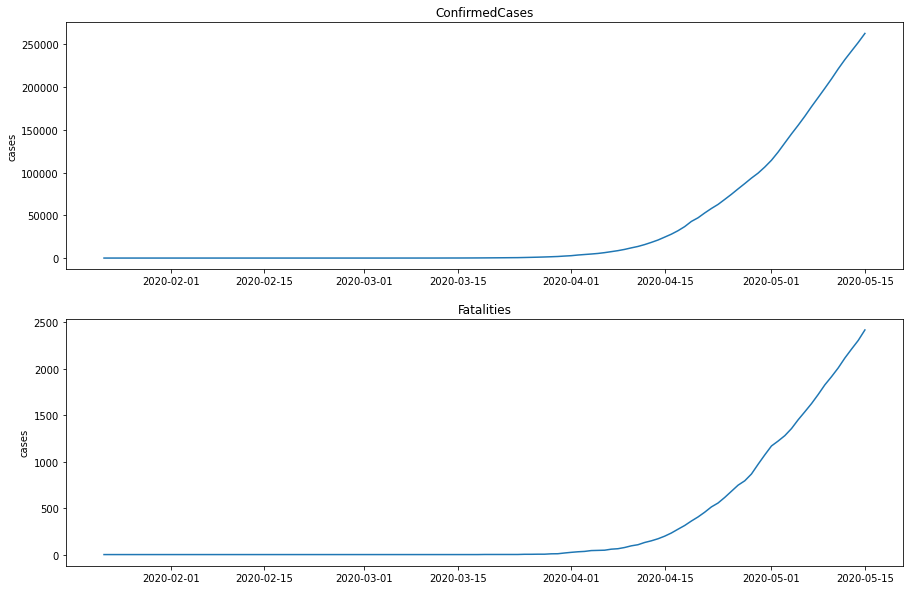

In [ ]:
# визуализируем данные
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1)

axs[0].plot(rus['Date'].values.astype('datetime64[D]'), rus['ConfirmedCases'].values)
axs[0].set_title('ConfirmedCases')
axs[0].set_ylabel('cases')

axs[1].plot(rus['Date'].values.astype('datetime64[D]'), rus['Fatalities'].values)
axs[1].set_title('Fatalities')
axs[1].set_ylabel('cases')

plt.show()

# 2 Построение моделей для данных по России

На графиках видно, что данные можно аппроксимировать с помощью полинома и полиномаильной регресии. Но для наглядности посторим ещё и линейную регрессию.

С помощью кросс-валидации подберём оптимальную степень аппроксимирующего полинома и степень полиномиальной регресии.

In [ ]:
def cross_validation(n_data, X, y, model, column_name):

  mapes = []
  maes = []
  degrees = np.arange(1, 100)
  min_mape, min_mae = 1e10, 1e10

  # Провалидируемся по степеням аппроксимирующего полинома и полиномиальной регрессии
  for deg in degrees:

    # Полиномиальная регрессия
    if model=='poly_reg':
      x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

      poly_features = PolynomialFeatures(degree=deg, include_bias=False)
      x_poly_train = poly_features.fit_transform(x_train)

      poly_reg = LinearRegression()
      poly_reg.fit(x_poly_train, y_train)

      x_poly_test = poly_features.fit_transform(x_test)
      poly_predict = poly_reg.predict(x_poly_test)

    # Аппроксимирующий полином
    elif model=='polynom':
      data = np.arange(n_data)
      x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.15, shuffle=False)
      p = np.poly1d(np.polyfit(x_train, y_train, deg=deg))

      poly_predict = p(x_test)

    # Рассчитаем метрики на тестовых данных
    # 1. MAPE:
    poly_mape = mean_absolute_percentage_error(y_test, poly_predict)
    mapes.append(poly_mape)
    
    # 2. MAE:
    poly_mae = mean_absolute_error(y_test, poly_predict)
    maes.append(poly_mae)

    # Кросс-валидация по степеням
    if min_mape > poly_mape:
        min_mape = poly_mape
        min_deg = deg
    if min_mae > poly_mae:
        min_mae = poly_mae
        min_deg_mae = deg
    # Графики
  print('Оптимальная степень для {} — {} с MAPE {},\n\t\t {} с MAE {}'.format(model, min_deg, min_mape, min_deg_mae, min_mae))

  fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

  axs[0].plot(degrees, mapes)
  axs[0].set_title(column_name)
  axs[0].set_ylabel('MAPE')
  axs[0].set_xlabel('Degree')

  axs[1].plot(degrees, maes)
  axs[1].set_title(column_name)
  axs[1].set_ylabel('MAE')
  axs[1].set_xlabel('Degree')

  plt.show()

  return min_deg, min_mape, min_deg_mae, min_mae

In [ ]:
# Построим модели для столбца ConfirmedCases
n_data = len(rus['Date'].values.astype('datetime64[D]'))

X = np.arange(n_data).reshape(n_data, 1)
y = np.array(rus['ConfirmedCases'])

Оптимальная степень для poly_reg — 4 с MAPE 0.03034500220240427,
		 4 с MAE 6434.971000798887


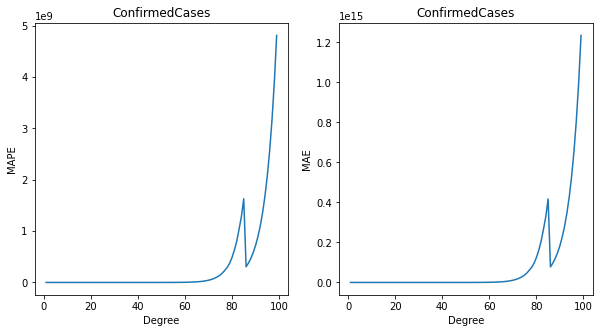

(4, 0.03034500220240427, 4, 6434.971000798887)

In [ ]:
# Аппроксимирующий полином
cross_validation(n_data=n_data, X=X, y=y, model='poly_reg', column_name='ConfirmedCases')

Оптимальная степень для polynom — 4 с MAPE 0.030345002197316687,
		 4 с MAE 6434.970999957049


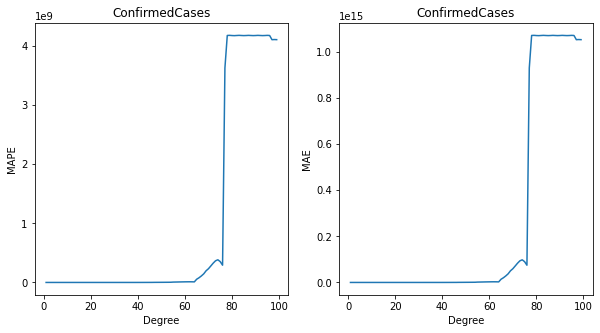

(4, 0.030345002197316687, 4, 6434.970999957049)

In [ ]:
# Полиномиальная регрессия
cross_validation(n_data=n_data, X=X, y=y, model='polynom', column_name='ConfirmedCases')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Рассчитаем метрики на тестовых данных
lin_predict = lin_reg.predict(x_test)
lin_mape = mean_absolute_error(y_test, lin_predict)
lin_mae = mean_absolute_percentage_error(y_test, lin_predict)

print('Метрики для линейной регрессии (ConfirmedCases): MAPE {},\n\t\t MAE {}'.format(lin_mape, lin_mae))

Метрики для линейной регрессии (ConfirmedCases): MAPE 138745.45415906914,
		 MAE 0.7822901163234252


Построим графики для оптимальных степеней аппроксимирующего полинома и полиномиальной регрессии, а также график линейной регрессии.

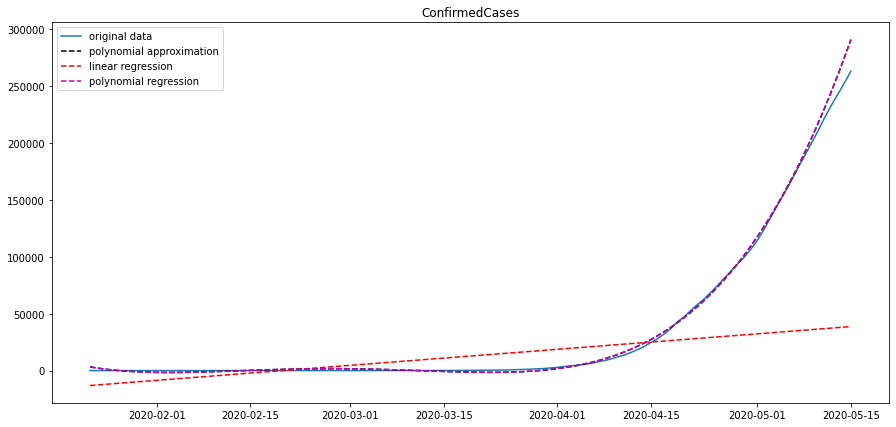

In [ ]:
X = np.arange(n_data).reshape(n_data, 1)
deg = 4

# Аппроксимирующий полином
data = np.arange(n_data)
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.15, shuffle=False)
p = np.poly1d(np.polyfit(x_train, y_train, deg=deg))
#polynom_predict = p(x_test)

# Полиномиальная регрессия
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

poly_features = PolynomialFeatures(degree=deg, include_bias=False)
x_poly_train = poly_features.fit_transform(x_train)

poly_reg = LinearRegression()
poly_reg.fit(x_poly_train, y_train)

X_poly = poly_features.transform(X)

# Графики
plt.figure(figsize=(15,7))
plt.plot(rus['Date'].values.astype('datetime64[D]'), rus['ConfirmedCases'].values, label='original data')
plt.plot(rus['Date'].values.astype('datetime64[D]'), p(data), 'k--', label='polynomial approximation')
plt.plot(rus['Date'].values.astype('datetime64[D]'), lin_reg.predict(X), 'r--', label='linear regression')
plt.plot(rus['Date'].values.astype('datetime64[D]'), poly_reg.predict(X_poly), 'm--', label='polynomial regression')
plt.title('ConfirmedCases')
plt.legend()
plt.show()

Поскольку полиномиальная регрессия и аппроксимация полиномом суть одно и то же, оптимальная степень получилась одинаковая, а графики практически совпали.

Поэтому для столбца **Fatalities** построим только полиномиальную регрессию.

Метрики **MAPE** и **MAE** для полиномиальная регрессии и аппроксимации полиномом практически равны (**3%** и **6435** соответственно), кроме того, они существенно меньше, чем для линейной регрессии (**78%** и **138745** соответственно).

In [ ]:
# Построим модели для столбца Fatalities
n_data = len(rus['Date'].values.astype('datetime64[D]'))

X = np.arange(n_data).reshape(n_data, 1)
y = np.array(rus['Fatalities'])

Оптимальная степень для polynom — 4 с MAPE 0.04872063049761397,
		 4 с MAE 85.73707755011498


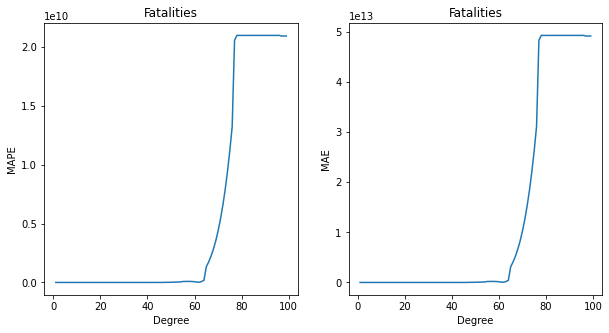

(4, 0.04872063049761397, 4, 85.73707755011498)

In [ ]:
# Полиномиальная регрессия
cross_validation(n_data=n_data, X=X, y=y, model='polynom', column_name='Fatalities')

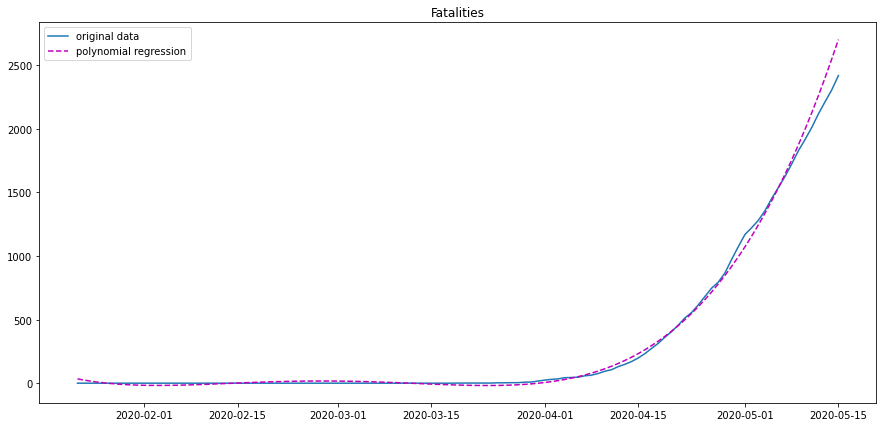

In [ ]:
deg = 4

# Полиномиальная регрессия
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

poly_features = PolynomialFeatures(degree=deg, include_bias=False)
x_poly_train = poly_features.fit_transform(x_train)

poly_reg = LinearRegression()
poly_reg.fit(x_poly_train, y_train)

X_poly = poly_features.transform(X)

# Графики
plt.figure(figsize=(15,7))
plt.plot(rus['Date'].values.astype('datetime64[D]'), rus['Fatalities'].values, label='original data')
plt.plot(rus['Date'].values.astype('datetime64[D]'), poly_reg.predict(X_poly), 'm--', label='polynomial regression')
plt.title('Fatalities')
plt.legend()
plt.show()

Метрики **MAPE** и **MAE** для столбца **Fatalities** (полиномиальная регрессия) равны **5%** и **86** соответственно. Степень полинома - **4**.

# 3 Построение моделей для данных по миру

In [ ]:
data = pd.read_csv(r"/content/train.csv", sep = ',') # загружаем данные в датафрейм
data['Date'] = pd.to_datetime(data['Date']) # изменяем формат столбца с датами
data.head(10)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
5,6,NaN,Afghanistan,2020-01-27,0.0,0.0
6,7,NaN,Afghanistan,2020-01-28,0.0,0.0
7,8,NaN,Afghanistan,2020-01-29,0.0,0.0
8,9,NaN,Afghanistan,2020-01-30,0.0,0.0
9,10,NaN,Afghanistan,2020-01-31,0.0,0.0


In [ ]:
data = data.groupby('Date').sum()
data.head(10)

,Id,ConfirmedCases,Fatalities
Date,,,
2020-01-22,5615533,554.0,17.0
2020-01-23,5615846,653.0,18.0
2020-01-24,5616159,939.0,26.0
2020-01-25,5616472,1432.0,42.0
2020-01-26,5616785,2113.0,56.0
2020-01-27,5617098,2922.0,82.0
2020-01-28,5617411,5573.0,131.0
2020-01-29,5617724,6161.0,133.0
2020-01-30,5618037,8229.0,171.0


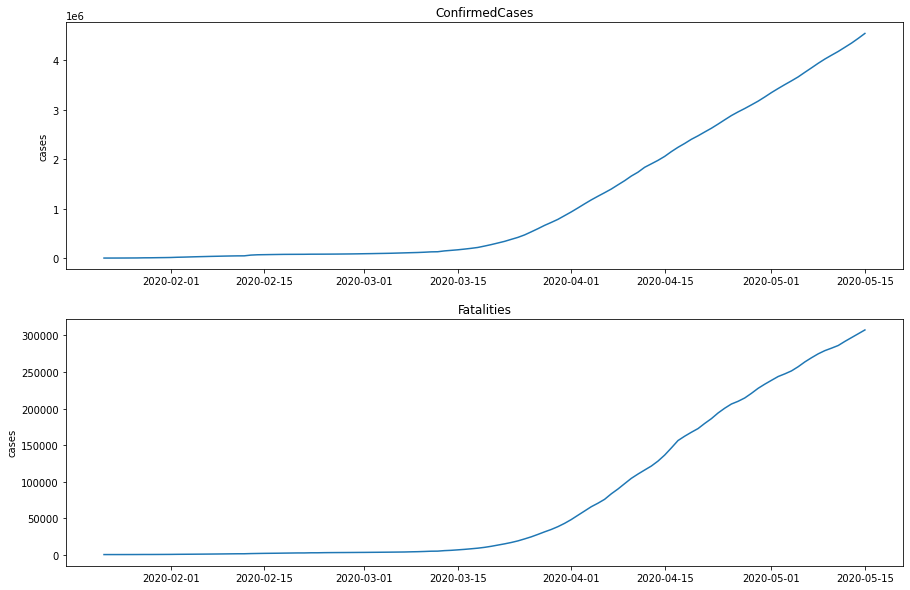

In [ ]:
# визуализируем данные
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=1)

axs[0].plot(data.index.values.astype('datetime64[D]'), data['ConfirmedCases'].values)
axs[0].set_title('ConfirmedCases')
axs[0].set_ylabel('cases')

axs[1].plot(data.index.values.astype('datetime64[D]'), data['Fatalities'].values)
axs[1].set_title('Fatalities')
axs[1].set_ylabel('cases')

plt.show()

In [ ]:
# Построим модели для столбца ConfirmedCases
n_data = len(data.index.values.astype('datetime64[D]'))

X = np.arange(n_data).reshape(n_data, 1)
y = np.array(data['ConfirmedCases'])

Оптимальная степень для poly_reg — 2 с MAPE 0.021285716814102917,
		 2 с MAE 86550.69634460908


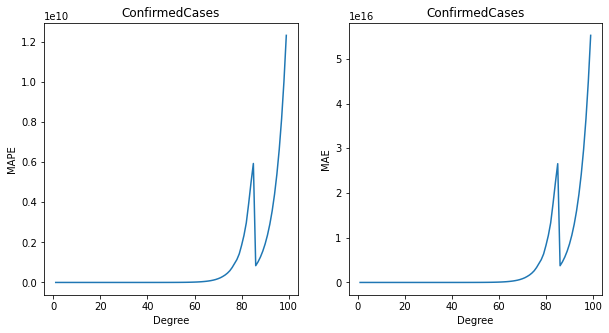

(2, 0.021285716814102917, 2, 86550.69634460908)

In [ ]:
# Аппроксимирующий полином
cross_validation(n_data=n_data, X=X, y=y, model='poly_reg', column_name='ConfirmedCases')

Оптимальная степень для polynom — 2 с MAPE 0.021285716814102865,
		 2 с MAE 86550.6963446089


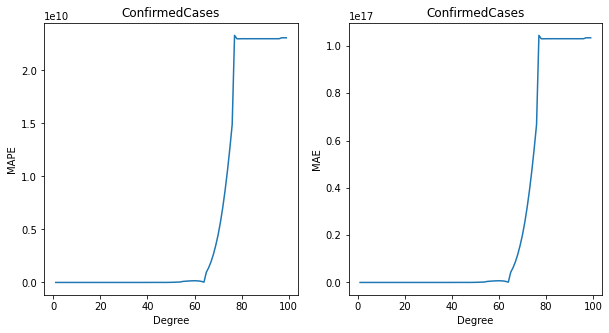

(2, 0.021285716814102865, 2, 86550.6963446089)

In [ ]:
# Полиномиальная регрессия
cross_validation(n_data=n_data, X=X, y=y, model='polynom', column_name='ConfirmedCases')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Рассчитаем метрики на тестовых данных
lin_predict = lin_reg.predict(x_test)
lin_mape = mean_absolute_error(y_test, lin_predict)
lin_mae = mean_absolute_percentage_error(y_test, lin_predict)

print('Метрики для линейной регрессии (ConfirmedCases): MAPE {},\n\t\t MAE {}'.format(lin_mape, lin_mae))

Метрики для линейной регрессии (ConfirmedCases): MAPE 1570779.9115843496,
		 MAE 0.40933863128993203


Построим графики для оптимальных степеней аппроксимирующего полинома и полиномиальной регрессии, а также график линейной регрессии.

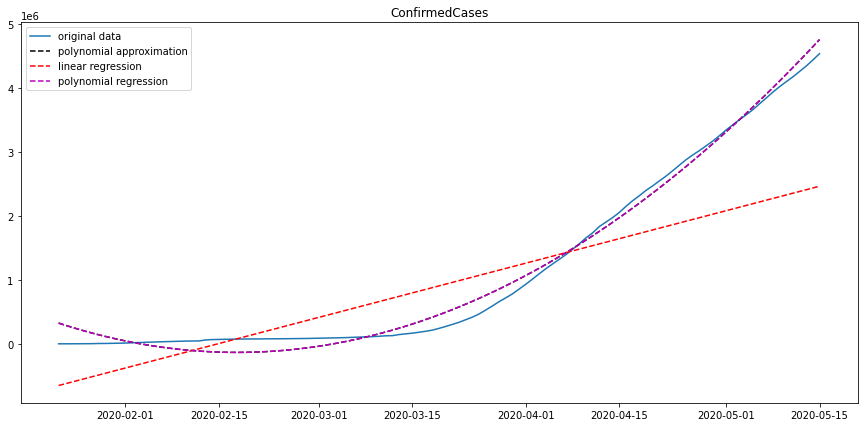

In [ ]:
X = np.arange(n_data).reshape(n_data, 1)
deg = 2

# Аппроксимирующий полином
data_ = np.arange(n_data)
x_train, x_test, y_train, y_test = train_test_split(data_, y, test_size=0.15, shuffle=False)
p = np.poly1d(np.polyfit(x_train, y_train, deg=deg))
#polynom_predict = p(x_test)

# Полиномиальная регрессия
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

poly_features = PolynomialFeatures(degree=deg, include_bias=False)
x_poly_train = poly_features.fit_transform(x_train)

poly_reg = LinearRegression()
poly_reg.fit(x_poly_train, y_train)

X_poly = poly_features.transform(X)

# Графики
plt.figure(figsize=(15,7))
plt.plot(data.index.values.astype('datetime64[D]'), data['ConfirmedCases'].values, label='original data')
plt.plot(data.index.values.astype('datetime64[D]'), p(data_), 'k--', label='polynomial approximation')
plt.plot(data.index.values.astype('datetime64[D]'), lin_reg.predict(X), 'r--', label='linear regression')
plt.plot(data.index.values.astype('datetime64[D]'), poly_reg.predict(X_poly), 'm--', label='polynomial regression')
plt.title('ConfirmedCases')
plt.legend()
plt.show()

Поскольку полиномиальная регрессия и аппроксимация полиномом суть одно и то же, оптимальная степень получилась одинаковая, а графики практически совпали.

Поэтому для столбца **Fatalities** построим только полиномиальную регрессию.

Метрики **MAPE** и **MAE** для полиномиальная регрессии и аппроксимации полиномом практически равны (**2%** и **86551** соответственно), кроме того, они существенно меньше, чем для линейной регрессии (**41%** и **1570779** соответственно).

Отметим, что визуально модель, полученная на данных по миру, аппроксимирует данные хуже, чем модель, построенная на данных по России. Тем не менее объективная метрика - средняя относительная ошибка - говорит об обратном (для модели по России она составила **4%**).

In [ ]:
# Построим модели для столбца Fatalities
n_data = len(data.index.values.astype('datetime64[D]'))

X = np.arange(n_data).reshape(n_data, 1)
y = np.array(data['Fatalities'])

Оптимальная степень для polynom — 9 с MAPE 0.03250328625003748,
		 9 с MAE 8962.993996285908


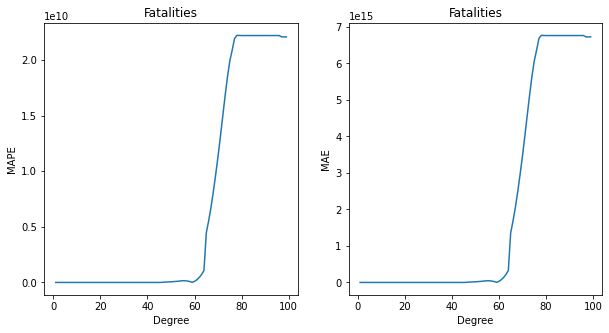

(9, 0.03250328625003748, 9, 8962.993996285908)

In [ ]:
# Полиномиальная регрессия
cross_validation(n_data=n_data, X=X, y=y, model='polynom', column_name='Fatalities')

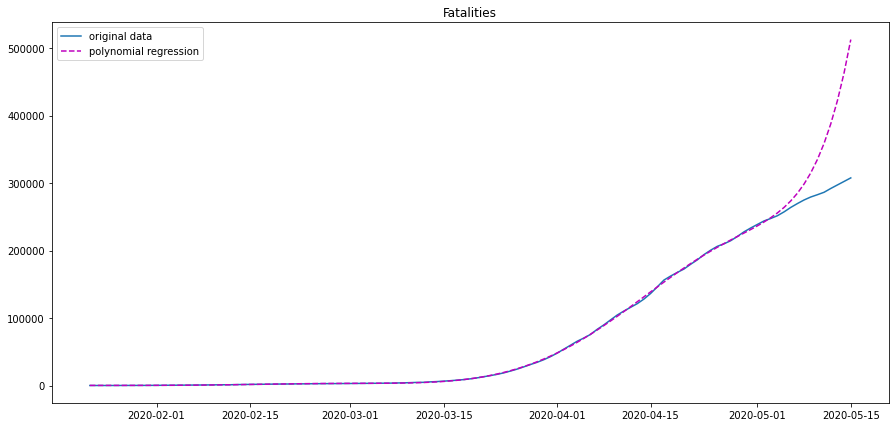

In [ ]:
deg = 9

# Полиномиальная регрессия
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

poly_features = PolynomialFeatures(degree=deg, include_bias=False)
x_poly_train = poly_features.fit_transform(x_train)

poly_reg = LinearRegression()
poly_reg.fit(x_poly_train, y_train)

X_poly = poly_features.transform(X)

# Графики
plt.figure(figsize=(15,7))
plt.plot(data.index.values.astype('datetime64[D]'), data['Fatalities'].values, label='original data')
plt.plot(data.index.values.astype('datetime64[D]'), poly_reg.predict(X_poly), 'm--', label='polynomial regression')
plt.title('Fatalities')
plt.legend()
plt.show()

Метрики **MAPE** и **MAE** для столбца **Fatalities** (полиномиальная регрессия) равны **3%** и **8962** соответственно. Степень полинома - **9**.

Очевидно, что модель переобучена, то есть для улучшения качества прогноза необходимо снизить степень полинома. Тем не менее по объективному показателю - средней относительной ошибке - степень 9 оптимальна.

# Выводы

В ходе настоящей работы были построены модели полиномальной регресии для прогнозирования заболеваемости и смертности от коронавируса.

Обучающая выборка составила **85%** данных, валидация моделей осуществлялась методом **отложенной выборки**.

Оптимальная степень полинома для моделей заболеваемости и смертности, обученная на данных **по России** составила **4** со значениями метрик:
- средняя относительная ошибка (MAPE) **3%** и **5%** для заболеваемости и смертности соответсвенно,

- средняя абсолютная ошибка (MAE) **6435** и **86** для заболеваемости и смертности соответсвенно.

Оптимальная степень полинома для модели заболеваемости, обученная на данных **по миру** составила **2**, а для смертности - **9** со значениями метрик:
- средняя относительная ошибка (MAPE) **2%** и **3%** для заболеваемости и смертности соответсвенно,

- средняя абсолютная ошибка (MAE) **86551** и **8962** для заболеваемости и смертности соответсвенно.

По объективной метрике MAPE все модели хорошего качества, однако, как показано для модели смертности по миру, имеется переобучение. Его можно обнаружить визуально либо с помощью других метрик. В настоящей работе использовалась дополнительная визуальная оценка.

